## set-up

In [724]:
import cv2
import subprocess
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
from skimage.transform import probabilistic_hough_line
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage.morphology import skeletonize, thin, opening, square
from skimage.filters import gaussian
from skimage import data

## loading test image
Please notice that there are different loading methods depending on the type of images from study 2 (with white backgrounds) and study 3 (with transparent backgrounds). Below, we are working with an example from study 3

In [725]:
# setting up paths

# getting local root of GitHub repository
repo_root = Path(subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip())

# specify drawing_sample folder
drawing_samples = repo_root / 'drawing_samples'

# specify study
study = 'STUDY3_drawing_samples'

# specify a file name from that study folder
file_name = 'Identity_Chain1_Seed4_Gen9.png'

# we can now assemble the path
file_path = str(drawing_samples / study / file_name)

In [726]:
# ======= When working with data from study 2, use this chunk – commented out for now ========

# # for png with white background
# test_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# # converting to binary
# _, img_bin = cv2.threshold(test_img, 127, 1, cv2.THRESH_BINARY_INV)

# plt.imshow(img_bin, cmap='gray')

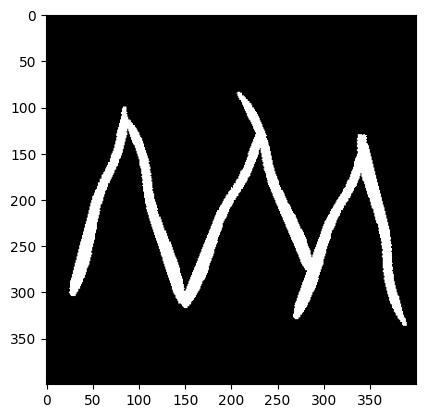

In [727]:
# ======= When working with data from study 3 (with transparent background), use this chunk ========
img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

# split channels
b, g, r, a = cv2.split(img)

# convert to greyscale; convert transparent pixels to white
gray = cv2.cvtColor(cv2.merge([b, g, r]), cv2.COLOR_BGR2GRAY)
gray[a == 0] = 255

# binarize
_, img_bin = cv2.threshold(gray, 127, 1, cv2.THRESH_BINARY_INV)

plt.imshow(img_bin, cmap='gray')

## Step 1: Fitting line elements within each line via Probabilistic Hough Transform
Documentation: https://scikit-image.org/docs/0.25.x/auto_examples/edges/plot_line_hough_transform.html

Please note that the results are very sensitive to how the parameters of the probabilistic_hough_line() are set. The current combination was reached through trial and error but the accuracy of this setting has not been assessed systematically yet.

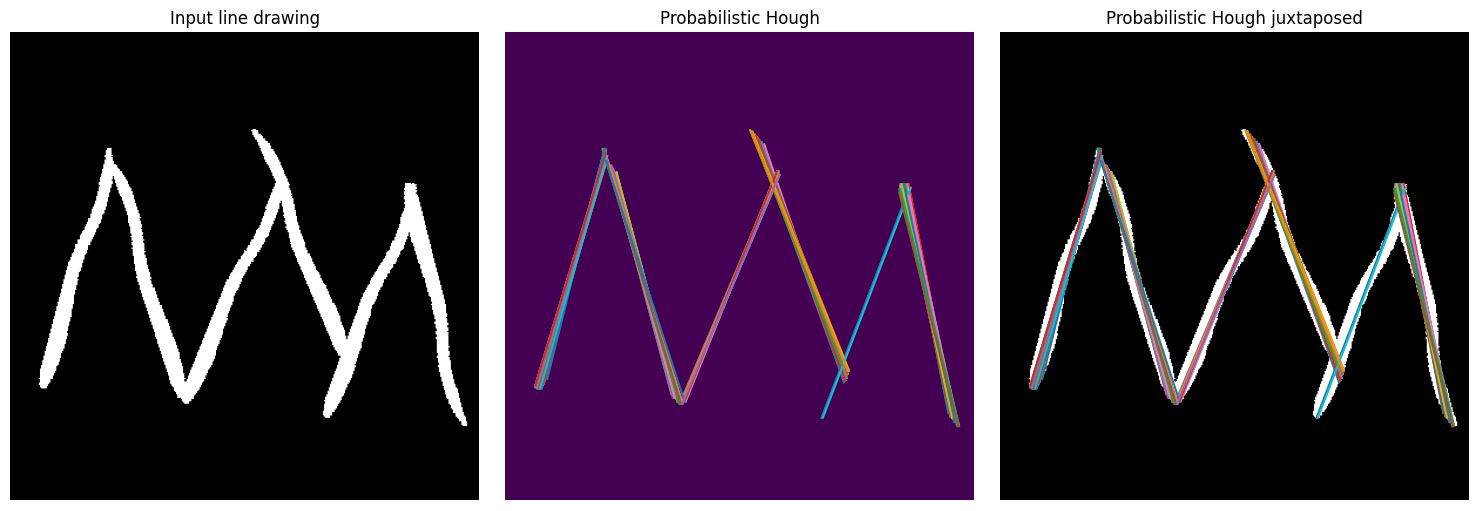

In [728]:
# Line finding using the Probabilistic Hough Transform
# image = img_bin
# lines = probabilistic_hough_line(image, 
#                                  threshold=0, 
#                                  line_length=190, 
#                                  line_gap=0)

### trying to loop this
image = img_bin

all_lines = []

for seed in range(15):
    np.random.seed(seed)
    lines = probabilistic_hough_line(image,
                                     threshold=30,
                                     line_length=195,
                                     line_gap=0)
    all_lines.extend(lines)

lines = all_lines

# plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input line drawing')

ax[1].imshow(image * 0)
for line in lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].set_xlim((0, image.shape[1]))
ax[1].set_ylim((image.shape[0], 0))
ax[1].set_title('Probabilistic Hough')

ax[2].imshow(image, cmap=cm.gray)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough juxtaposed')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

All lines are covered with line segments from start to finish. The next step would be to find a single 'average' line from these line segments, that can cover each actual line from origin to end point.

## Step 2: Creating line representations for clustering

Here, some features of all sublines are computed and stored as a new data structure. 

The idea is to be able to cluster the linesegments within each actual line based on their midpoints and orientations, following the rationale that sublines with very similar midpoints and orientations will belong to the same actual line.

In [729]:
# # writing midpoint function
# def find_midpoint(line_segment):

#     x_1 = line_segment[0][0]
#     y_1 = line_segment[0][1]
#     x_2 = line_segment[1][0]
#     y_2 = line_segment[1][1]
    
#     midpoint = [(x_1+x_2)/2,(y_1+y_2)/2]

#     return midpoint

In [730]:
# # writing orientation function
# def find_orientation(line_segment):

#     x_1 = line_segment[0][0]
#     y_1 = line_segment[0][1]
#     x_2 = line_segment[1][0]
#     y_2 = line_segment[1][1]

#     # dx = x_2 - x_1
#     # dy = y_2 - y_1
#     # angle = np.arctan2(dy, dx)

#     # first we compute the slope - this gives div by 0 issues...
#     if x_2 == x_1:
#         slope = np.inf  # dealing with vertical lines
#     else:    
#         slope = (y_2-y_1) / (x_2-x_1)

#     # then we find the angle using arctan - they should maybe be 'standardized' to make opposite vectors the same (see BTL script for approach...)
#     orientation = math.atan(slope) 

#     return orientation


In [731]:
# # making new line representations
# line_tupples = []

# for line_segment in lines:
#     midpoint = find_midpoint(line_segment)
#     orientation = find_orientation(line_segment)
#     representation = {'x': midpoint[0], 'y': midpoint[1], 'orientation': orientation}
    
#     # adding the representation to the new data frame
#     line_tupples.append(representation)

# # converting to a dataframe
# lines_df = pd.DataFrame(line_tupples)

In [732]:
# # plotting the data to see visually if clusters occur
# from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

# df = lines_df

# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(df['x'], df['y'], df['orientation'], c='red', s=50)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Orientation (rad)')
# ax.set_title('Line midpoints with orientations in 3D')

# plt.show()

In [733]:
##### Alternative method using terminal points

# unnesting the terminal point coordinates for each line (to make each line a single tupple)
line_term_tupples = [(x1, y1, x2, y2) for ((x1, y1), (x2, y2)) in lines]

# turning it into a dataframe
line_term_tupples_df = pd.DataFrame(data = line_term_tupples, columns=['x_1', 'y_1', 'x_2', 'y_2'])
line_term_tupples_df.head()

,x_1,y_1,x_2,y_2
0,26,301,86,102
1,383,332,344,130
2,149,317,86,108
3,150,315,233,119
4,290,297,213,88


## Step 3: Clustering (labelling) sublines

This part of the script is still very much a work in progress. The idea is to use clustering algorithms to group the lines. Immediate results seem very mixed.

In [734]:
# # approach using midpoints; commented out

# # clustering the lines using KMeans
# kmeans = KMeans(init="k-means++", n_clusters=6, n_init=300)
# kmeans.fit(lines_df)

# kmeans.cluster_centers_
# kmeans.labels_

# # adding the clustering information to a new line dataframe
# clustered_lines = lines_df
# clustered_lines['cluster_labels'] = kmeans.labels_[:]

# # plotting the lines colored by label
# df = clustered_lines

# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(df['x'], df['y'], df['orientation'], c=df['cluster_labels'], cmap='tab10', s=50)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Orientation (rad)')
# ax.set_title('Clustered lines')

# plt.show()

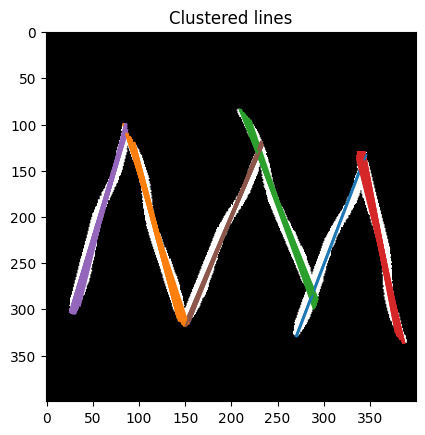

In [735]:
# approach using terminal points and K-means

# clustering the lines using KMeans
kmeans = KMeans(init="k-means++", n_clusters=6, n_init=300)
kmeans.fit(line_term_tupples_df)

# adding the clustering information to a new line dataframe
clustered_lines = line_term_tupples_df
clustered_lines['cluster_labels'] = kmeans.labels_[:]

# clustered_lines.head()

# plotting lines colored by label
fig, ax = plt.subplots()
ax.imshow(image, cmap=cm.gray)
ax.set_title('Clustered lines')

for _, row in clustered_lines.iterrows():
    ax.plot(row[['x_1', 'x_2']], row[['y_1', 'y_2']], 
            color=f'C{int(row["cluster_labels"])}')
plt.show()

In [736]:
# ## approach adding direction
# angles = np.arctan2(
#     clustered_lines['y_2'] - clustered_lines['y_1'],
#     clustered_lines['x_2'] - clustered_lines['x_1']
# )
# lengths = np.sqrt(
#     (clustered_lines['x_2'] - clustered_lines['x_1'])**2 + 
#     (clustered_lines['y_2'] - clustered_lines['y_1'])**2
# )

# # Create feature matrix with weights
# features = np.column_stack([
#     clustered_lines['x_1'],
#     clustered_lines['y_1'],
#     clustered_lines['x_2'],
#     clustered_lines['y_2'],
#     angles * 1, # adjust the weight of angles      
#     # lengths,
# ])

# # cluster
# n_lines = 6
# kmeans = KMeans(init="k-means++", n_clusters=6, n_init=300)
# kmeans.fit(features)

# # adding the clustering information to a new line dataframe
# clustered_lines = line_term_tupples_df
# clustered_lines['cluster_labels'] = kmeans.labels_[:]

# # plotting lines colored by label
# fig, ax = plt.subplots()
# ax.imshow(image, cmap=cm.gray)
# ax.set_title('Clustered lines')

# for _, row in clustered_lines.iterrows():
#     ax.plot(row[['x_1', 'x_2']], row[['y_1', 'y_2']], 
#             color=f'C{int(row["cluster_labels"])}')
# plt.show()

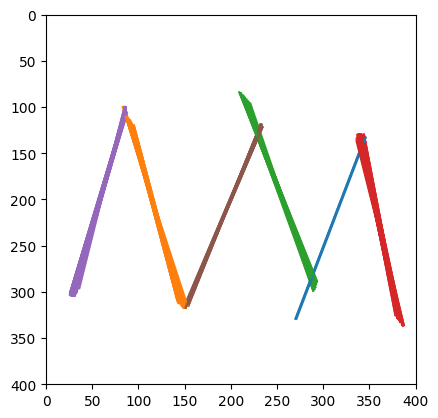

In [737]:
# plotting lines colored by label
fig, ax = plt.subplots()
for _, row in clustered_lines.iterrows():
    ax.plot(row[['x_1', 'x_2']], row[['y_1', 'y_2']], 
            color=f'C{int(row["cluster_labels"])}')
ax.set_xlim(0,400)
ax.set_ylim(400,0)
ax.set_aspect('equal') 

plt.show()

## Trying out the hessian normal form

In [738]:
def endpoints_to_hesse(df, x1="x_1", y1="y_1", x2="x_2", y2="y_2"):
    x1v = df[x1].values
    y1v = df[y1].values
    x2v = df[x2].values
    y2v = df[y2].values

    dx = x2v - x1v
    dy = y2v - y1v
    L = np.hypot(dx, dy)
    L[L == 0] = np.nan

    # unit normal
    nx =  dy / L
    ny = -dx / L

    # angle
    theta = np.mod(np.arctan2(ny, nx), np.pi)

    # signed distance
    rho = x1v * nx + y1v * ny

    # enforce rho >= 0
    flip = rho < 0
    rho[flip] *= -1
    theta[flip] = np.mod(theta[flip] + np.pi/2, np.pi)

    df_out = df.copy()
    df_out["theta"] = theta
    df_out["rho"] = rho
    return df_out


In [739]:
# # converting to hesse form
# line_term_tupples_df.pop('cluster_labels')
# hesse_df = endpoints_to_hesse(df = line_term_tupples_df)

In [740]:
# # trying clustering on this new representation

# # cluster
# n_lines = 6
# kmeans = KMeans(init="k-means++", n_clusters=6, n_init=300)
# kmeans.fit(hesse_df)

# # adding the clustering information to a new line dataframe
# clustered_lines = hesse_df
# clustered_lines['cluster_labels'] = kmeans.labels_[:]

# # plotting lines colored by label
# fig, ax = plt.subplots()
# ax.imshow(image, cmap=cm.gray)
# ax.set_title('Clustered lines')

# for _, row in clustered_lines.iterrows():
#     ax.plot(row[['x_1', 'x_2']], row[['y_1', 'y_2']], 
#             color=f'C{int(row["cluster_labels"])}')
# plt.show()

## Step 4: Find average lines

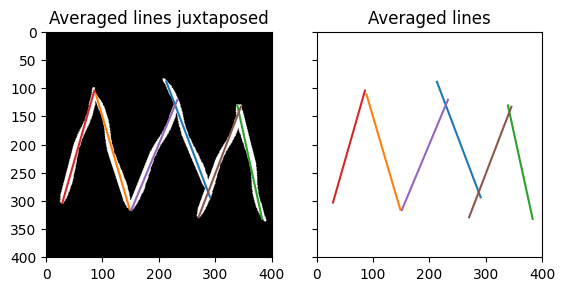

In [723]:
method = 'mean'

# finding average lines
avg_lines = clustered_lines.groupby('cluster_labels').agg({
    'x_1': method,
    'y_1': method,
    'x_2': method,
    'y_2': method,
    'cluster_labels': 'first',
})

# plotting
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

# plotting on top of image
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Averaged lines juxtaposed')

for _, row in avg_lines.iterrows():
    ax[0].plot(row[['x_1', 'x_2']], row[['y_1', 'y_2']], 
            color=f'C{int(row["cluster_labels"])}')

# plotting without image
ax[1].set_title('Averaged lines')

for _, row in avg_lines.iterrows():
    ax[1].plot(row[['x_1', 'x_2']], row[['y_1', 'y_2']], 
            color=f'C{int(row["cluster_labels"])}')

ax[1].set_xlim(0,400)
ax[1].set_ylim(400,0)
ax[1].set_aspect('equal') 

plt.show()


Actually, the fact that overlapping lines can result in 'too long' averaged lines could be considered a feature instead of a problem; the idea is anyways to find intersections, and when lines overlap, that would just be easier?